In [ ]:
!pip3 install pydot
!pip3 install pydotplus
!pip3 install graphviz
#brew install graphviz

In [ ]:
https://github.com/hexiangnan/neural_collaborative_filtering/blob/4aab159e81c44b062c091bdaed0ab54ac632371f/GMF.py#L83

### Dataset

In [1]:
# key : user, value : item list
user_map = {}
max_item_id = -1
with open('u.data') as f:
    lines = f.readlines()
    for line in lines:
        # user id | item id | rating | timestamp
        user_id, item_id, rating, timestamp = line[:-1].split('\t')
        
        user_id = int(user_id)
        item_id = int(item_id)
        
        if user_id not in user_map :
            user_map[user_id] = []
        user_map[user_id].append(item_id)
        
        max_item_id = max(max_item_id, item_id)
        
num_users = len(user_map)
num_items = max_item_id
print('num_users: {}, num_items: {}'.format(num_users, num_items))

num_users: 943, num_items: 1682


In [2]:
import random

X_user = []
X_item = []
y = []

for user_id in user_map :
    pos_items = user_map[user_id]
    pos_item_cnt = len(pos_items)
    for item_id in pos_items :
        X_user.append(user_id)
        X_item.append(item_id)
        y.append(1)
    neg_item_sample = [item_id for item_id in range(1, num_items + 1) if item_id not in pos_items]
    #neg_items = random.sample(neg_item_sample, pos_item_cnt) # put same number of neg items with pos items
    neg_items = random.sample(neg_item_sample, 2) # put same number of neg items with pos items
    for item_id in neg_items :
        X_user.append(user_id)
        X_item.append(item_id)
        y.append(0)

### Model

In [3]:
# python GMF.py --dataset ml-1m --epochs 20 --batch_size 256 --num_factors 8 --regs [0,0] --num_neg 4 --lr 0.001 --learner adam --verbose 1 --out 1
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Flatten, Dense
import numpy as np

user_input_dim = num_users + 1
item_input_dim = num_items + 1

latent_dim = 4

'''
# user1 : item1, item2
# user2 : item1, item3
# user3 : item1, item4
# user4 : item1, item5
# user5 : item1, item2


# (2 pos / 2 neg) per user 
train_user_input = [1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5]
train_item_input = [1, 2, 3, 4, 1, 3, 2, 5, 1, 4, 2, 5, 1, 5, 2, 3, 1, 2, 3, 4]
train_labels = [1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0]

print(len(train_user_input), len(train_item_input), len(train_labels))
'''

# Input variables
user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
item_input = Input(shape=(1,), dtype='int32', name = 'item_input')

MF_Embedding_User = tf.keras.layers.Embedding(input_dim = user_input_dim, output_dim = latent_dim, name = 'user_embedding',
                              embeddings_initializer='uniform', input_length=1)
MF_Embedding_Item = tf.keras.layers.Embedding(input_dim = item_input_dim, output_dim = latent_dim, name = 'item_embedding',
                              embeddings_initializer='uniform', input_length=1)   

# Crucial to flatten an embedding vector!
user_latent = tf.keras.layers.Flatten()(MF_Embedding_User(user_input))
item_latent = tf.keras.layers.Flatten()(MF_Embedding_Item(item_input))

# Element-wise product of user and item embeddings 
predict_vector = tf.keras.layers.Multiply()([user_latent, item_latent])

# Final prediction layer
prediction = tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.LecunUniform(), name='prediction')(predict_vector)


model = tf.keras.Model(inputs=[user_input, item_input], outputs=prediction)

model.compile(optimizer=tf.keras.optimizers.Adagrad(lr=0.001), loss='binary_crossentropy', metrics=['mse'])

hist = model.fit([np.array(X_user), np.array(X_item)], #input
                 np.array(y), # labels 
                 batch_size=256, epochs=20, verbose=1, shuffle=True)

Epoch 1/20
398/398 [==============================] - 0s 751us/step - loss: 0.6814 - mse: 0.2441
Epoch 2/20
398/398 [==============================] - 0s 1ms/step - loss: 0.6710 - mse: 0.2389A: 0s - loss: 0.6739 - mse:
Epoch 3/20
398/398 [==============================] - 0s 747us/step - loss: 0.6644 - mse: 0.2356
Epoch 4/20
398/398 [==============================] - 0s 801us/step - loss: 0.6591 - mse: 0.2330
Epoch 5/20
398/398 [==============================] - 0s 760us/step - loss: 0.6545 - mse: 0.2307
Epoch 6/20
398/398 [==============================] - 0s 722us/step - loss: 0.6504 - mse: 0.2287
Epoch 7/20
398/398 [==============================] - 0s 787us/step - loss: 0.6468 - mse: 0.2268
Epoch 8/20
398/398 [==============================] - 0s 699us/step - loss: 0.6434 - mse: 0.2251
Epoch 9/20
398/398 [==============================] - 0s 739us/step - loss: 0.6403 - mse: 0.2236
Epoch 10/20
398/398 [==============================] - 0s 738us/step - loss: 0.6373 - mse: 0.2221
Epoc

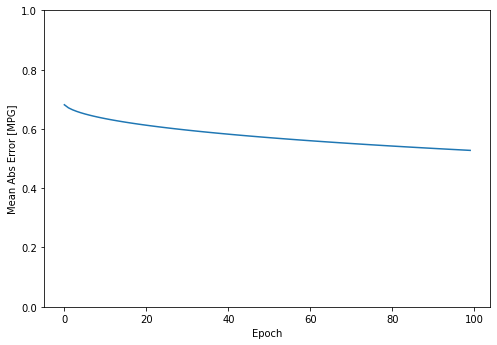

In [157]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,12))

  plt.subplot(2,1,1)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['loss'],
           label='Train Error')
  plt.ylim([0,1])
  plt.show()

plot_history(hist)

In [148]:
#196
print(list(user_map[196]))

[242, 393, 381, 251, 655, 67, 306, 238, 663, 111, 580, 25, 286, 94, 692, 8, 428, 1118, 70, 66, 257, 108, 202, 340, 287, 116, 382, 285, 1241, 1007, 411, 153, 13, 762, 173, 1022, 845, 269, 110]


In [138]:
user = np.array([196 for i in range(item_input_dim - 1)])
item = np.array([i for i in range(1, item_input_dim)])

pred = model.predict([user, item])

In [145]:
list_ = [t for t in zip(item, pred.reshape(-1))]
sorted(list_, key=lambda x : x[1], reverse=True)

[(1677, 0.63042444),
 (160, 0.6304034),
 (1569, 0.6304029),
 (838, 0.6304018),
 (743, 0.63039756),
 (430, 0.6303875),
 (461, 0.6303851),
 (85, 0.6303768),
 (439, 0.630376),
 (124, 0.6303693),
 (1339, 0.6303651),
 (1667, 0.6303626),
 (958, 0.6303604),
 (1226, 0.63035905),
 (543, 0.63035727),
 (1636, 0.6303571),
 (1374, 0.63035685),
 (1340, 0.6303539),
 (1382, 0.630352),
 (1229, 0.6303518),
 (1603, 0.63035065),
 (103, 0.63035035),
 (1555, 0.6303485),
 (672, 0.6303474),
 (1656, 0.6303456),
 (145, 0.6303439),
 (1637, 0.6303424),
 (949, 0.6303412),
 (797, 0.63034046),
 (75, 0.63033897),
 (1404, 0.6303376),
 (200, 0.63033724),
 (1268, 0.6303372),
 (480, 0.63033605),
 (646, 0.63033366),
 (412, 0.6303333),
 (203, 0.6303323),
 (766, 0.63033116),
 (399, 0.63033104),
 (597, 0.6303291),
 (628, 0.630328),
 (888, 0.6303272),
 (48, 0.63032556),
 (696, 0.63032347),
 (1190, 0.63031864),
 (1228, 0.63031805),
 (1130, 0.630318),
 (870, 0.6303171),
 (741, 0.6303168),
 (327, 0.6303158),
 (1209, 0.6303156),


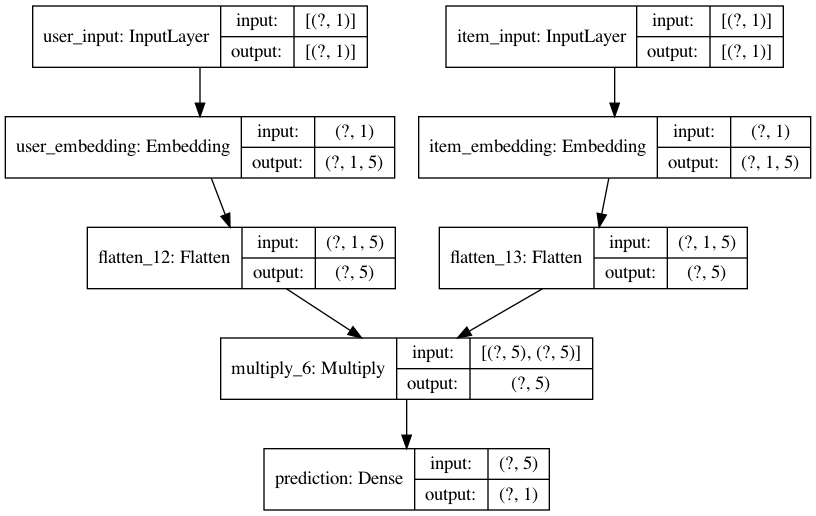

In [13]:
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### MLP

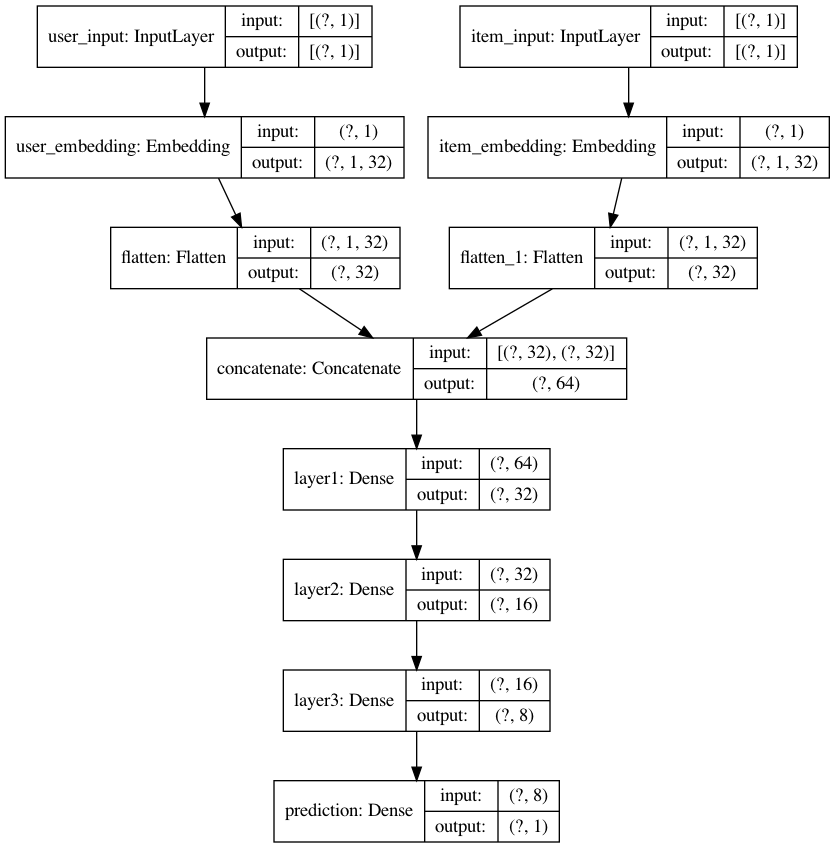

In [3]:
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Flatten, Dense
import numpy as np

user_input_dim = num_users + 1
item_input_dim = num_items + 1

layers = [64,32,16,8]
num_layer = len(layers)

user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
item_input = Input(shape=(1,), dtype='int32', name = 'item_input')

MLP_Embedding_User = Embedding(input_dim = user_input_dim, output_dim = int(layers[0]/2), name = 'user_embedding',
                              embeddings_initializer='uniform', input_length=1)
MLP_Embedding_Item = Embedding(input_dim = item_input_dim, output_dim = int(layers[0]/2), name = 'item_embedding',
                              embeddings_initializer='uniform', input_length=1)

# Crucial to flatten an embedding vector!
user_latent = Flatten()(MLP_Embedding_User(user_input))
item_latent = Flatten()(MLP_Embedding_Item(item_input))

# The 0-th layer is the concatenation of embedding layers
vector = tf.keras.layers.Concatenate()([user_latent, item_latent])

# MLP layers
for idx in range(1, num_layer):
    layer = Dense(layers[idx], activation='relu', name = 'layer%d' %idx)
    vector = layer(vector)

# Final prediction layer
prediction = Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.LecunUniform(), name='prediction')(vector)


model = Model(inputs=[user_input, item_input], outputs=prediction)

tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [4]:
model.compile(optimizer=tf.keras.optimizers.Adagrad(lr=0.001), loss='binary_crossentropy', metrics=['mse'])

hist = model.fit([np.array(X_user), np.array(X_item)], #input
                 np.array(y), # labels 
                 batch_size=256, epochs=20, verbose=1, shuffle=True)

Epoch 1/20
398/398 [==============================] - 0s 1ms/step - loss: 0.6503 - mse: 0.2286
Epoch 2/20
398/398 [==============================] - 0s 1ms/step - loss: 0.5938 - mse: 0.2005
Epoch 3/20
398/398 [==============================] - 0s 1ms/step - loss: 0.5446 - mse: 0.1764
Epoch 4/20
398/398 [==============================] - 1s 1ms/step - loss: 0.4963 - mse: 0.1532
Epoch 5/20
398/398 [==============================] - 1s 1ms/step - loss: 0.4483 - mse: 0.1309
Epoch 6/20
398/398 [==============================] - 1s 1ms/step - loss: 0.4014 - mse: 0.1099
Epoch 7/20
398/398 [==============================] - 0s 1ms/step - loss: 0.3569 - mse: 0.0911
Epoch 8/20
398/398 [==============================] - 0s 1ms/step - loss: 0.3160 - mse: 0.0749A: 0s - loss: 0.3169 - mse: 0.075
Epoch 9/20
398/398 [==============================] - 0s 1ms/step - loss: 0.2794 - mse: 0.0615
Epoch 10/20
398/398 [==============================] - 0s 1ms/step - loss: 0.2476 - mse: 0.0508
Epoch 11/20
398/

### NCF

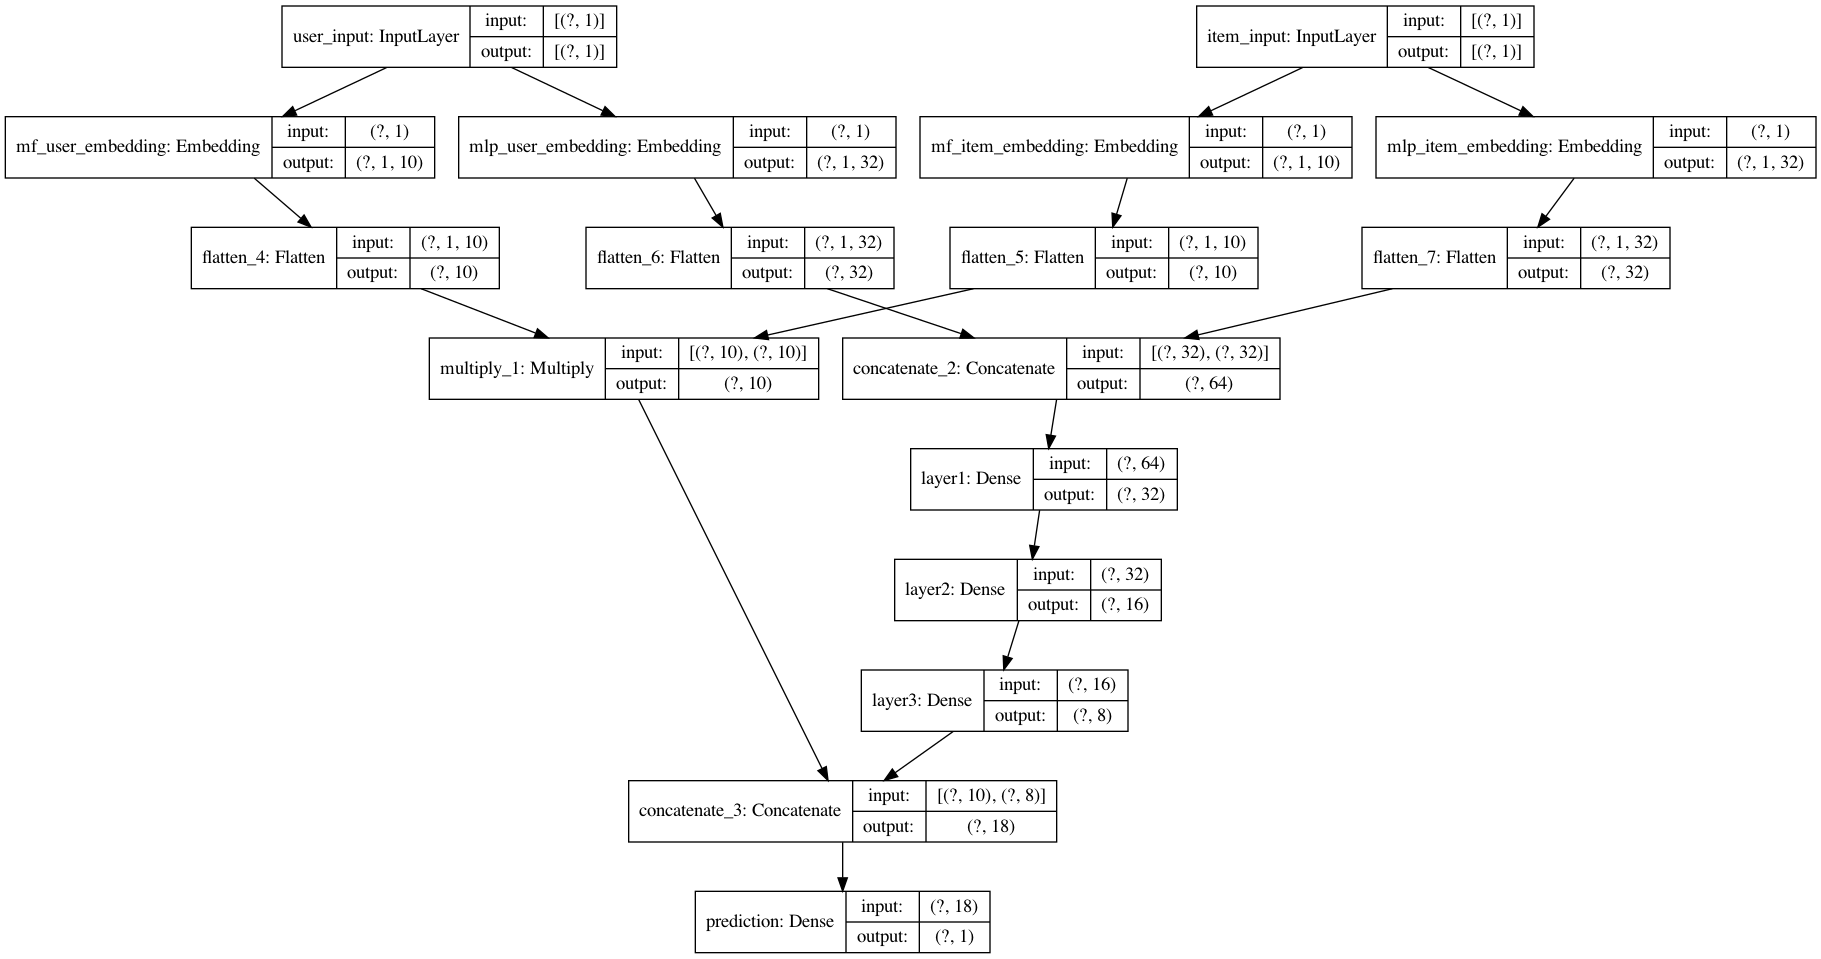

In [10]:
# python NeuMF.py --dataset ml-1m --epochs 20 --batch_size 256 --num_factors 8 --layers [64,32,16,8] --reg_mf 0 --reg_layers [0,0,0,0] --num_neg 4 --lr 0.001 --learner adam --verbose 1 --out 1
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Flatten, Dense
import numpy as np

layers = [64, 32, 16, 8]
mf_dim=10
num_layer = len(layers) #Number of layers in the MLP

user_input_dim = num_users + 1
item_input_dim = num_items + 1

# Input variables
user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
item_input = Input(shape=(1,), dtype='int32', name = 'item_input')

# Embedding layer
MF_Embedding_User = Embedding(input_dim = user_input_dim, output_dim = mf_dim, name = 'mf_user_embedding',
                              embeddings_initializer='uniform', input_length=1)
MF_Embedding_Item = Embedding(input_dim = item_input_dim, output_dim = mf_dim, name = 'mf_item_embedding',
                              embeddings_initializer='uniform', input_length=1)   

MLP_Embedding_User = Embedding(input_dim = user_input_dim, output_dim = int(layers[0]/2), name = 'mlp_user_embedding',
                              embeddings_initializer='uniform', input_length=1)
MLP_Embedding_Item = Embedding(input_dim = item_input_dim, output_dim = int(layers[0]/2), name = 'mlp_item_embedding',
                              embeddings_initializer='uniform', input_length=1)   

# MF part
mf_user_latent = Flatten()(MF_Embedding_User(user_input))
mf_item_latent = Flatten()(MF_Embedding_Item(item_input))
mf_vector = tf.keras.layers.Multiply()([mf_user_latent, mf_item_latent])

# MLP part 
mlp_user_latent = Flatten()(MLP_Embedding_User(user_input))
mlp_item_latent = Flatten()(MLP_Embedding_Item(item_input))
mlp_vector = tf.keras.layers.Concatenate()([mlp_user_latent, mlp_item_latent])
for idx in range(1, num_layer):
    layer = Dense(layers[idx], activation='relu', name = 'layer%d' %idx)
    mlp_vector = layer(mlp_vector)

# Concatenate MF and MLP parts
#mf_vector = Lambda(lambda x: x * alpha)(mf_vector)
#mlp_vector = Lambda(lambda x : x * (1-alpha))(mlp_vector)
predict_vector = tf.keras.layers.Concatenate()([mf_vector, mlp_vector])

# Final prediction layer
prediction = Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.LecunUniform(), name='prediction')(predict_vector)

model = Model(inputs=[user_input, item_input], 
              outputs=prediction)

tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [11]:
model.compile(optimizer=tf.keras.optimizers.Adagrad(lr=0.001), loss='binary_crossentropy', metrics=['mse'])

hist = model.fit([np.array(X_user), np.array(X_item)], #input
                 np.array(y), # labels 
                 batch_size=256, epochs=20, verbose=1, shuffle=True)

Epoch 1/100
398/398 [==============================] - 1s 1ms/step - loss: 0.6600 - mse: 0.2334
Epoch 2/100
398/398 [==============================] - 1s 1ms/step - loss: 0.6144 - mse: 0.2108
Epoch 3/100
398/398 [==============================] - 1s 1ms/step - loss: 0.5728 - mse: 0.1902
Epoch 4/100
398/398 [==============================] - 1s 1ms/step - loss: 0.5308 - mse: 0.1697
Epoch 5/100
398/398 [==============================] - 1s 2ms/step - loss: 0.4876 - mse: 0.1491
Epoch 6/100
398/398 [==============================] - 1s 1ms/step - loss: 0.4437 - mse: 0.1288A: 0s - loss: 0.4538 - mse: 0
Epoch 7/100
398/398 [==============================] - 1s 1ms/step - loss: 0.4001 - mse: 0.1093
Epoch 8/100
398/398 [==============================] - 1s 1ms/step - loss: 0.3580 - mse: 0.0915
Epoch 9/100
398/398 [==============================] - 1s 1ms/step - loss: 0.3186 - mse: 0.0758
Epoch 10/100
398/398 [==============================] - 0s 1ms/step - loss: 0.2828 - mse: 0.0627
Epoch 11/1

KeyboardInterrupt: 